In [3]:
import sys
if('/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path):
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import operator

# Logic

1. find color histogram 
2. calculate difference of color histogram between previous and current frame. (cv2.HISTCMP_CORREL & cv2.HISTCMP_KL_DIV)
3. we have two list of difference for entire video using two differnt methods
4. perform element wise subtraction of correlation with klDivergence -> new list
5. find value < 0. this is the frame with hands most of the time . add offset of 10 or 15 and you got it.
6. With too dark video you will never get. So suggetion is amplify klDiv by 10 and check if (value <0 and index < 15)

# check with the video which is similar and not similar

1. 57 perfect video ( 6 + buffer = 16 or 20)
2. 46 objects taking more time to settle(10 + buffer = 20th or 25th frame)
3. 96 too dark video (delet this is outlier multiply liner by 20 then it will detect)
4. 94 too dark video2 (approach is working)
5. 82 too bright (9+buffer = 20)
6. 64 too dark (5 + buffer = 20)
7. 242 Extreme dark (3 + buffer = 15) : PASS
8. 315 Half dark half bright : PASS
9. 339 extreme bright + variation in the brightness : pass
10. 341 Black background : pass

In [15]:
vid_path = "/media/pritesh/Entertainment/cvData/VideoPackage1_1/CV19_video_64.avi"
cap = cv2.VideoCapture(vid_path)
# cap = cv2.VideoCapture("../data/VideoPackage1_1/CV19_video_64.avi")
success, frame_prev = cap.read() #read 1st frame
# quit if unable to read the video file
if not success:
    print('Failed to read video')
    sys.exit(1)

# correlation cv2.HISTCMP_CORREL
#chi-squared cv2.HISTCMP_CHISQR
#intersection cv2.HISTCMP_INTERSECT
#hellinger cv2.HISTCMP_BHATTACHARYYA

hist_correlation =[]
hist_hellinger = []
hist_kldiv = []
count = 0
while cap.isOpened():
    success, frame_next = cap.read()
    if not success:
        break
    hist_prev = cv2.calcHist([frame_prev], [0,1,2], None, [8,8,8], [0,256,0,256,0,256])
    hist_prev = cv2.normalize(hist_prev, hist_prev).flatten()
    
    hist_next = cv2.calcHist([frame_next], [0,1,2], None, [8,8,8], [0,256,0,256,0,256])
    hist_next = cv2.normalize(hist_next, hist_next).flatten()
    hist_correlation.append(cv2.compareHist(hist_prev, hist_next, cv2.HISTCMP_CORREL))
    hist_hellinger.append(cv2.compareHist(hist_prev, hist_next, cv2.HISTCMP_BHATTACHARYYA))
    hist_kldiv.append(cv2.compareHist(hist_prev, hist_next, cv2.HISTCMP_KL_DIV)*80)
    
    frame_prev = frame_next

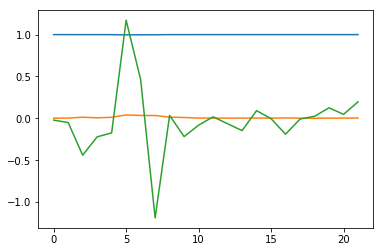

In [6]:
plt.plot(hist_correlation)
plt.plot(hist_hellinger)
plt.plot(hist_kldiv)

In [8]:
diff = list(map(operator.sub, hist_correlation, hist_kldiv))

In [9]:
np.where(np.array(diff)<0)

(array([5]),)

In [ ]:
def get_frame(vid_path, frame_num):
    cap = cv2.VideoCapture(vid_path)
    success, frame = cap.read() #read 1st frame
    # quit if unable to read the video file
    if not success:
        print('Failed to read video')
        sys.exit(1)

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    success, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame
def plot_for_report(vid_path, corr, kldiv,index, save_name):
    im = get_frame(vid_path, index)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    ax1.imshow(im)
    ax2.plot(kldiv)
    ax2.plot(corr)
    ax2.axvline(index)
    fig.savefig("frame_detection_out/{}".format(save_name))
im = get_frame("../data/VideoPackage1_1/CV19_video_64.avi",5)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.imshow(im)
ax2.plot(hist_kldiv)
ax2.plot(hist_correlation)
ax2.axvline(5)

# Visualize your result

In [24]:
def get_frame(vid_path, frame_num):
    cap = cv2.VideoCapture(vid_path)
    success, frame = cap.read() #read 1st frame
    # quit if unable to read the video file
    if not success:
        print('Failed to read video')
        sys.exit(1)

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    success, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame
def plot_for_report(vid_path, corr, kldiv,index, save_name):
    im = get_frame(vid_path, index)
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
    ax1.imshow(im)
    ax2.plot(kldiv)
    ax2.plot(corr)
    ax2.axvline(index,color='red',label=index)
    ax2.legend()
    
    im = get_frame(vid_path, index+12)
    ax3.imshow(im)
    ax4.plot(kldiv)
    ax4.plot(corr)
    ax4.axvline(index+12,color='red',label=index+12)
    ax4.legend()
#     fig.savefig("frame_detection_out/{}".format(save_name))

def get_frame_index(correlation, kldiv):
    b = True #To run loop untill we get the frame number
    mul_factor = 1 #To amplify the kldiv by factor of 1o (only for too dark videos)
    kldiv = np.array(kldiv)
    correlation = np.array(correlation)
    frame_index = None
    while(b):
        diff = correlation - kldiv
        index = np.where(diff<0)[0]
        if(len(index)):
            if(mul_factor>1 and index[0] > 15): #The index of the frame should be less than 15 (if its more definately its wrong)
                kldiv = kldiv*10*mul_factor #Amplify the difference by 10,20,30,40 and so on
                mul_factor += mul_factor
                if(mul_factor>20): #try amplifying upto 200, still not found? then stop
                    print("cannot find the still frame index")
                    break
            else: #this means we got the frame in one shot and video is normal
                frame_index = index[0] 
                if(frame_index<20):
                    b = False
                else:
                    mul_factor +=1
        else:
            kldiv = kldiv*10*mul_factor #Amplify the difference by 10,20,30,40 and so on
            mul_factor += mul_factor
            if(mul_factor>20): #try amplifying upto 200, still not found? then stop
                print("cannot find the still frame index")
                break
    return frame_index

In [22]:
vid_path = "/media/pritesh/Entertainment/cvData/VideoPackage1_1/CV19_video_64.avi"
cap = cv2.VideoCapture(vid_path)
success, frame_prev = cap.read() #read 1st frame
# quit if unable to read the video file
if not success:
    print('Failed to read video')
    sys.exit(1)

hist_correlation =[]
hist_kldiv = []
count = 0
while cap.isOpened():
    success, frame_next = cap.read()
    if not success:
        break
    hist_prev = cv2.calcHist([frame_prev], [0,1,2], None, [8,8,8], [0,256,0,256,0,256])
    hist_prev = cv2.normalize(hist_prev, hist_prev).flatten()
    
    hist_next = cv2.calcHist([frame_next], [0,1,2], None, [8,8,8], [0,256,0,256,0,256])
    hist_next = cv2.normalize(hist_next, hist_next).flatten()
    hist_correlation.append(cv2.compareHist(hist_prev, hist_next, cv2.HISTCMP_CORREL))
    hist_kldiv.append(cv2.compareHist(hist_prev, hist_next, cv2.HISTCMP_KL_DIV))
    
    frame_prev = frame_next
    
index = get_frame_index(hist_correlation,hist_kldiv)


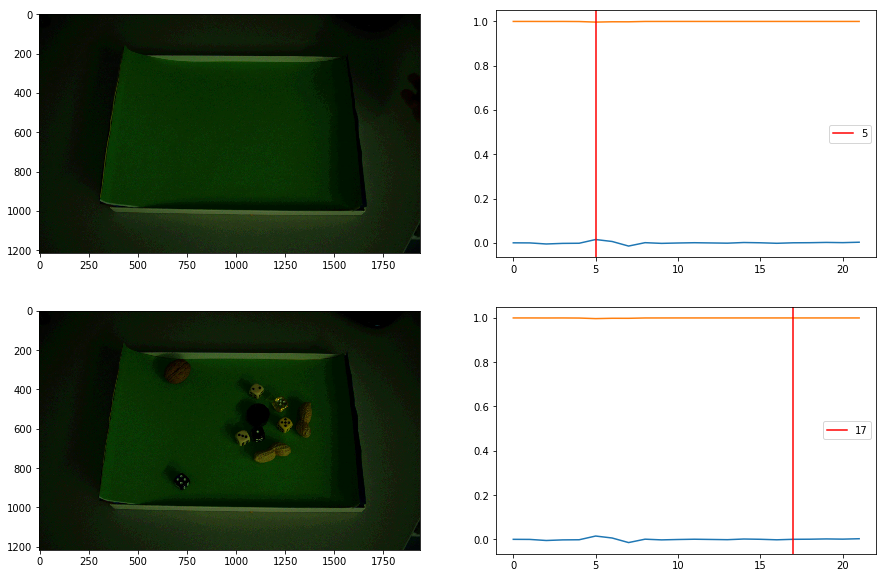

In [25]:
plot_for_report(vid_path,hist_correlation,hist_kldiv,index,"vid_64_{}".format(index))
# plot_for_report(vid_path,hist_correlation,hist_kldiv,index+12,"vid_341_{}".format(index+12))